<a href="https://colab.research.google.com/github/jeffheaton/stylegan2-toys/blob/master/morph_video_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Jeff Heaton](https://raw.githubusercontent.com/jeffheaton/present/master/images/github.jpg)

Copyright 2021 by [Jeff Heaton](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw), [released under Apache 2.0 license](https://github.com/jeffheaton/present/blob/master/LICENSE)
# StyleGAN2 Morph Between Two REAL Images

This notebook allows you to choose a starting and ending image and use StyleGAN2 to produce a "morph" video between the two pictures.  For the morph to work correctly, both images should be of human faces.  It helps if both pictures are cropped reasonably well to a square portrait to eliminate the possibility of two faces being present in one image.  The preprocessing code will lock in on the exact positioning of each image, so your crop does not have to be perfect. The main point of your crop is for you to remove anything else that might be confused for a face.  If multiple faces are detected, you will receive an error.

Also, make sure you have selected a GPU Runtime from CoLab. Choose "Runtime," then "Change Runtime Type," and choose GPU for "Hardware Accelerator."

The following YouTube video describes precisely how to run this notebook.

[Morphing Real Images to Video with StyleGAN2 ADA](http://youtube.com)

These settings allow you to change the high-level configuration.  The number of steps determines how long your resulting video is.  The video plays at 30 frames a second, so 150 is 5 seconds. You can also specify freeze steps to leave the video unchanged at the beginning and end. You will not likely need to change the network.


In [7]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

# Upload Starting Image

Choose your starting image.

In [8]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving kevin_j.jpg to kevin_j.jpg


Also, choose your ending image.

In [9]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving andrew_l.jpg to andrew_l.jpg


# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [10]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2023-11-20 02:21:55--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  7.10MB/s    in 0.8s    

2023-11-20 02:21:56 (7.10 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.


In [11]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


# Preprocess Images for Best StyleGAN Results

The following are helper functions for the preprocessing.

In [29]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)

  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  print(f"shape: {shape}")
  print(f"ex shape: {shape.num_parts}")
  print(f"ex shape: {shape.part(0)}")
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  print(f"features: {features}")
  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

shape: <_dlib_pybind11.full_object_detection object at 0x7e2ac0eab0f0>
ex shape: 5
ex shape: (494, 367)
features: [(0, (494, 367)), (1, (444, 366)), (2, (308, 360)), (3, (361, 363)), (4, (400, 462))]
shape: <_dlib_pybind11.full_object_detection object at 0x7e2ac01a4f70>
ex shape: 5
ex shape: (1958, 1717)
features: [(0, (1958, 1717)), (1, (1862, 1716)), (2, (1606, 1704)), (3, (1705, 1711)), (4, (1779, 1898))]
shape: <_dlib_pybind11.full_object_detection object at 0x7e2ac21850b0>
ex shape: 5
ex shape: (113, 66)
features: [(0, (113, 66)), (1, (101, 65)), (2, (71, 64)), (3, (83, 65)), (4, (92, 87))]
shape: <_dlib_pybind11.full_object_detection object at 0x7e2ac01a7cf0>
ex shape: 5
ex shape: (1988, 1585)
features: [(0, (1988, 1585)), (1, (1884, 1583)), (2, (1629, 1570)), (3, (1734, 1576)), (4, (1807, 1764))]


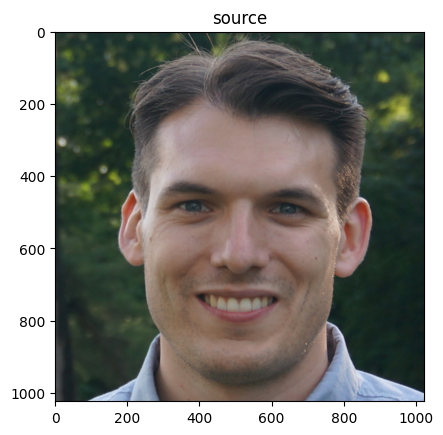

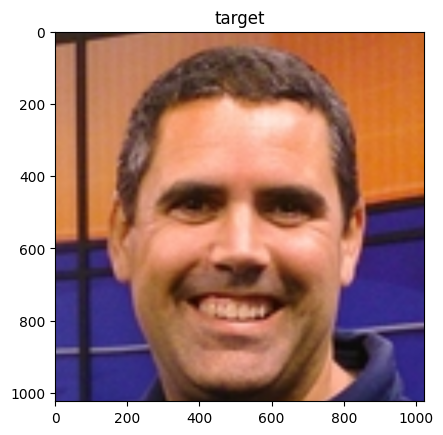

True

In [30]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

# Convert Source to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [14]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/projector.py", line 22, in <module>
    import dnnlib
ModuleNotFoundError: No module named 'dnnlib'


# Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [15]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/projector.py", line 22, in <module>
    import dnnlib
ModuleNotFoundError: No module named 'dnnlib'


With the conversion complete, lets have a look at the two GANs.

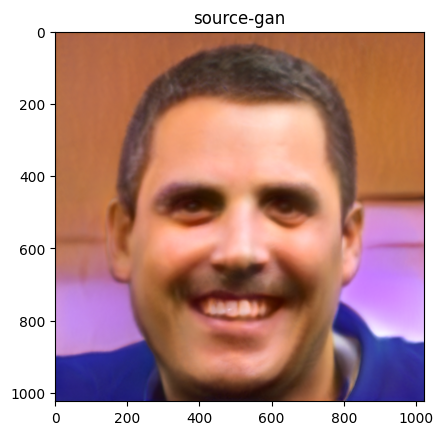

In [16]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

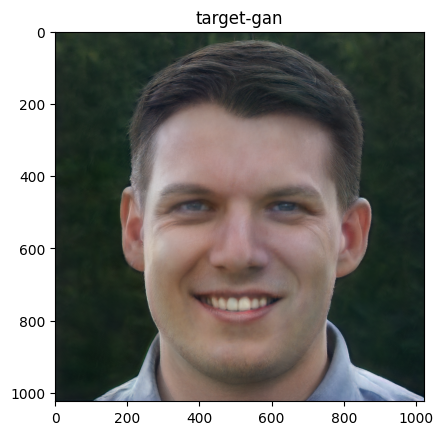

In [17]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [18]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1

  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [19]:
from google.colab import files
files.download("movie.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>